In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# *Exploratory data analysis* (EDA)

Esse notebook é dedicado exclusivamente para a exploração dos dados, com o objetivo de identificar padrões e correlações dos dados com a várivavel alvo (`Transported`). Vou tentar deixar o mais geral que consigo, para que essas funções sejam aplicáveis para outros conjuntos de dados.

## Carregando os dados

In [2]:
train_pd = pd.read_csv('train.csv')
test_pd = pd.read_csv('test.csv')

X_train = train_pd.drop('Transported', axis=1)
Y_train = train_pd['Transported'].copy()
Y_train = Y_train.astype(int)

## Contextualizando o problema

Antes de começar a de fato olhar para os dados preciso falar sobre o problema que está sendo atacado. No ano de 2912 a espaçonave Titanic colidiu com uma anomalia no espaço tempo escondida atrás de uma nuvem de poeira, e em torno de **metade** dos quase 13000 passageiros desapareceram. Desses quase 13000 estão disponíveis a situação (desaparecido ou não) de algumas pessoas apenas, e a nossa tarefa é treinar um modelo com os dados dessas pessoas cuja situação é conhecida para descobrir quais pessoas foram transportadas ou não do outro conjunto de dados, onde não se sabe se a pessoa foi afetada pela anomalia.

In [16]:
print(f'Sei a situação de {train_pd.shape[0]} passageiros e preciso descobrir a situação de {test_pd.shape[0]} passageiros ({train_pd.shape[0]+test_pd.shape[0]} passageiros no total)')

Sei a situação de 8693 passageiros e preciso descobrir a situação de 4277 passageiros (12970 passageiros no total)


## Definindo as funções para visualizar os dados

Aqui vou criar algumas funções importantes para a visualização e exploração de um conjunto com diferentes tipos de dados. Por enquanto esses conjuntos de funções será utlizado para exibir um *bar plot* com o número de *missing values* por *feature* (para preparar o processo de imputação), analisar histogramas dos dados numéricos afim de ver sua distribuição em relação à variável alvo (por exemplo, como está distribuída a *feature* `Age` para as pessoas que foram transportada? Está igual à das pessoas que não foram transportadas?), criar *pie plots* com os valores únicos das variáveis categóricas e analisara frequência das variáveis binárias, e também olhar para algumas outras características numéricas através da função .describe() do pandas. 

In [90]:
def count_miss(df: pd.DataFrame, dscb=True):
    #Função que plota um gráficos de barras para indicar quantos valores faltam no conjunto de dados
    # df --> dataframe
    # dscb --> Mostrar descrição geral dos dados

    if dscb:
        print(df.describe(include='all'))
    
    miss = df.isnull().sum() #dataframe com os missing values

    plt.figure(figsize=(10, 5))
    cores = plt.cm.get_cmap('hsv', len(miss)) #mapa de cores

    barras = plt.bar(range(len(miss)), miss.values, color=cores(range(len(miss))))

    plt.xticks([])
    plt.ylabel('Número de Missing Values')
    plt.title('Missing Values por Coluna')

    plt.legend(barras, [f"{idx}: {val}" for idx, val in miss.items()], bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.show()

def hist_num(df: pd.DataFrame, ftrs, uplim=9e20, downlim=-1, nolim=[], nb=60, dscb=True, df_test=False):
    # Função que plota histogramas para as variáveis numéricas e no final mostra a matriz de correlação entre as variáveis.
    # dataframe com os dados
    # ftrs --> lista com nomes das colunas com features numéricas
    # uplim --> limite superior para o plot
    # downlim --> limite ingerior para o plot
    # nolim --> Lista com colunas que não são afetadas pelo uplim e downlim (Aqui usada apenas para 'Age')
    # nb --> Número de canais nos histogramas
    # dscb --> Mostrar descrição geral dos dados
    # df_test --> Se for o df de teste (não houver a variável alvo) colocar True

    if dscb:
        print(df.describe(include='all'))

    for col in ftrs:
        plt.figure(figsize=(10, 5))
        if (col in nolim) & (df_test):
            nozero = df[(df[col] > downlim) & (df[col] < uplim)][[col, 'Transported']].copy().fillna(0)
            sns.histplot(data=nozero, x=col, hue='Transported', 
                    bins=nb, kde=False, element='bars', legend=True)
            plt.title(f'Distribuição de {col} por Status de Transporte')
            plt.show()
            continue
        elif df_test:
            nozero = df[(df[col] > downlim) & (df[col] < uplim)][[col, 'Transported']].copy().fillna(0)
            sns.histplot(data=nozero, x=col, hue='Transported', 
                    bins=nb, kde=False, element='bars', legend=True)
            plt.title(f'Distribuição de {col} por Status de Transporte')
            plt.show()
        else:
            sns.histplot(data=df, x=col, 
                    bins=nb, kde=False, element='bars', legend=True)
            plt.title(f'Distribuição de {col} por Status de Transporte')

    

    if df_test:
        df_cp = df.copy() #Criando uma cópia para não alterar os dados
        df_cp['TransportedNum'] = df_cp['Transported'].astype(int) #Converte boolean pra int

        comat = df_cp[ftrs+['TransportedNum']].corr() #dataframe quadrado, correspodente à matriz de correlação

        plt.figure(figsize=(10,8))
        sns.heatmap(comat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) #mapa de calor da matriz de correlação
        plt.title('Matriz de correlação entre Features numéricas e Target')
        plt.show()
    
def pieplots(df: pd.DataFrame, ftrs, dscb=True, df_test=False):
    # Função que plota histogramas para as variáveis numéricas.
    # dataframe com os dados
    # ftrs --> lista com nomes das colunas com features categóricas e binárias

    fs = 12 #tamanho da fonte

    if dscb:
        print(df.describe(include='all'))
    
    if df_test:
        for col in ftrs:
            sns.set_style("whitegrid")
            fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
            
            counts_trans = df[col].value_counts().sort_index()
            ax1.pie(
                counts_trans, 
                labels=counts_trans, 
                autopct='%1.1f%%', 
                startangle=90, 
                textprops={'fontsize':fs},
                labeldistance=.75,
                pctdistance = .5
                )
            ax1.set_title(f'{col} da amostra teste', fontsize=fs+2)
            ax1.legend(
                [
                    f'{idx} (total: {val:.0f})' for idx,val in counts_trans.items()
                    ], 
                    bbox_to_anchor=(.9, 1), 
                    fontsize=fs
                    )
        return

    for col in ftrs:
        counts_all = df[col].value_counts() #contagem de todos valores únicos

        sns.set_style("whitegrid")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5)) #subplot, com 2 plots para cada conjunto de dados

        #primeiro plot (transportados)
        counts_trans = df[df['Transported']==True][col].value_counts().sort_index()
        ax1.pie(
            counts_trans, 
            labels=counts_trans, 
            autopct='%1.1f%%', 
            startangle=90, 
            textprops={'fontsize':fs},
            labeldistance=.75,
            pctdistance = .5
            )
        ax1.set_title(f'{col} de quem foi transportado', fontsize=fs+2)
        ax1.legend(
            [
                f'{idx} ({val/sum(counts_all)*100:.1f}% das amostras, \n {counts_all[idx]/sum(counts_all)*100:.1f}% são {idx})' for idx,val in counts_trans.items()
                ], 
                bbox_to_anchor=(.9, 1), 
                fontsize=fs
                )

        #segundo plot (NÃO transportados)
        counts_nottrans = df[df['Transported']==False][col].value_counts().sort_index()
        ax2.pie(
            counts_nottrans, 
            labels=counts_nottrans, 
            autopct='%1.1f%%', 
            startangle=90, 
            textprops={'fontsize':fs},
            labeldistance=.75,
            pctdistance = .5
            )
        ax2.set_title(f'{col} de quem NÃO foi transportado', fontsize=fs+2)
        ax2.legend(
            [
                f'{idx} ({val/sum(counts_all)*100:.1f}% das amostras, \n {counts_all[idx]/sum(counts_all)*100:.1f}% são {idx})' for idx,val in counts_nottrans.items()
                ], 
                bbox_to_anchor=(.9, 1), 
                fontsize=fs
                )

In [27]:
categorical_features = ['HomePlanet', 'Destination']
binary_features = ['CryoSleep', 'VIP']
numerical_features = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

       PassengerId HomePlanet CryoSleep    Cabin  Destination          Age  \
count         8693       8492      8476     8494         8511  8514.000000   
unique        8693          3         2     6560            3          NaN   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e          NaN   
freq             1       4602      5439        8         5915          NaN   
mean           NaN        NaN       NaN      NaN          NaN    28.827930   
std            NaN        NaN       NaN      NaN          NaN    14.489021   
min            NaN        NaN       NaN      NaN          NaN     0.000000   
25%            NaN        NaN       NaN      NaN          NaN    19.000000   
50%            NaN        NaN       NaN      NaN          NaN    27.000000   
75%            NaN        NaN       NaN      NaN          NaN    38.000000   
max            NaN        NaN       NaN      NaN          NaN    79.000000   

          VIP   RoomService     FoodCourt  ShoppingMall        

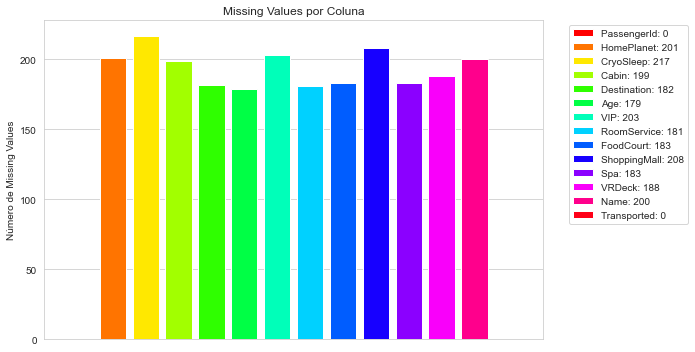

In [50]:
count_miss(train_pd)

       PassengerId HomePlanet CryoSleep    Cabin  Destination          Age  \
count         8693       8492      8476     8494         8511  8514.000000   
unique        8693          3         2     6560            3          NaN   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e          NaN   
freq             1       4602      5439        8         5915          NaN   
mean           NaN        NaN       NaN      NaN          NaN    28.827930   
std            NaN        NaN       NaN      NaN          NaN    14.489021   
min            NaN        NaN       NaN      NaN          NaN     0.000000   
25%            NaN        NaN       NaN      NaN          NaN    19.000000   
50%            NaN        NaN       NaN      NaN          NaN    27.000000   
75%            NaN        NaN       NaN      NaN          NaN    38.000000   
max            NaN        NaN       NaN      NaN          NaN    79.000000   

          VIP   RoomService     FoodCourt  ShoppingMall        

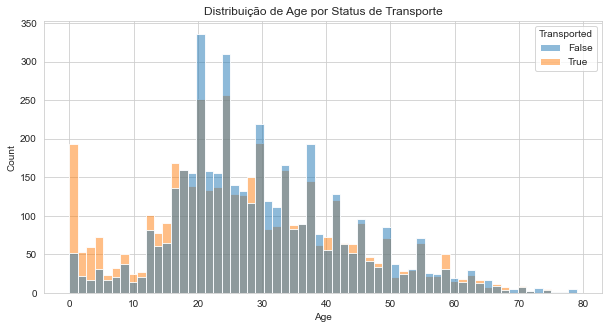

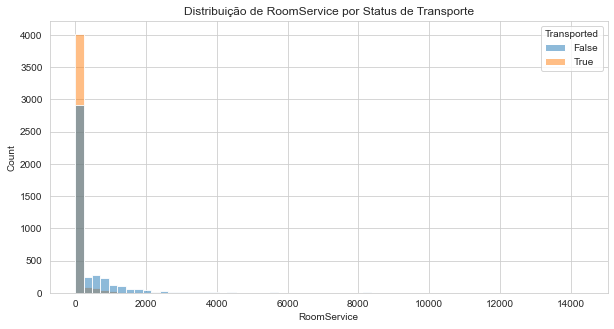

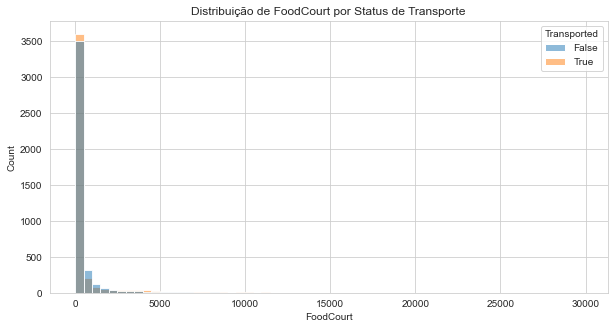

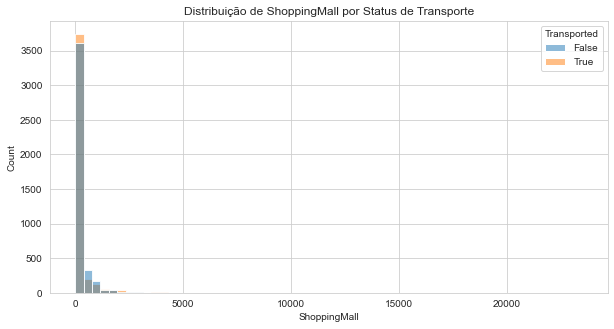

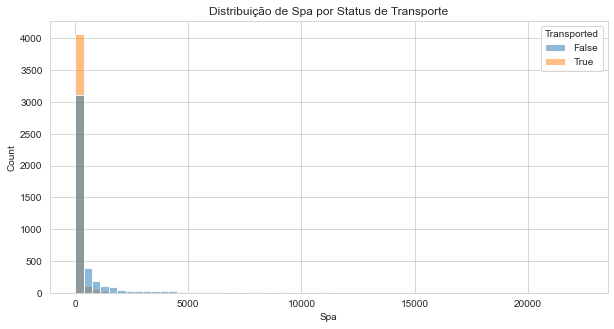

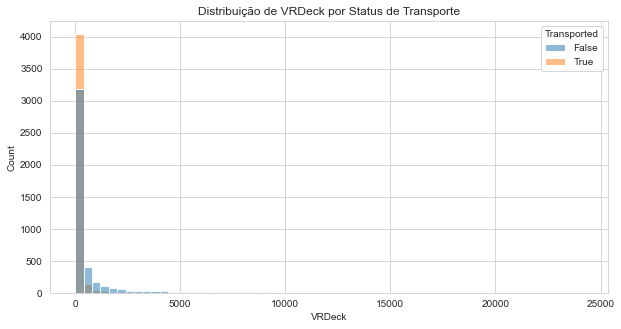

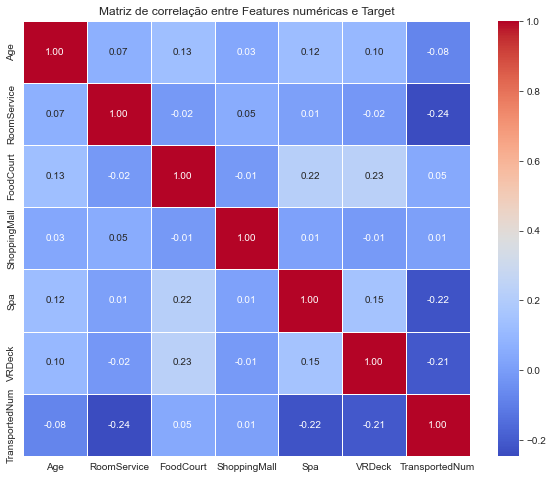

In [51]:
hist_num(train_pd, ftrs=numerical_features, nolim=['Age'])

       PassengerId HomePlanet CryoSleep    Cabin  Destination          Age  \
count         8693       8492      8476     8494         8511  8514.000000   
unique        8693          3         2     6560            3          NaN   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e          NaN   
freq             1       4602      5439        8         5915          NaN   
mean           NaN        NaN       NaN      NaN          NaN    28.827930   
std            NaN        NaN       NaN      NaN          NaN    14.489021   
min            NaN        NaN       NaN      NaN          NaN     0.000000   
25%            NaN        NaN       NaN      NaN          NaN    19.000000   
50%            NaN        NaN       NaN      NaN          NaN    27.000000   
75%            NaN        NaN       NaN      NaN          NaN    38.000000   
max            NaN        NaN       NaN      NaN          NaN    79.000000   

          VIP   RoomService     FoodCourt  ShoppingMall        

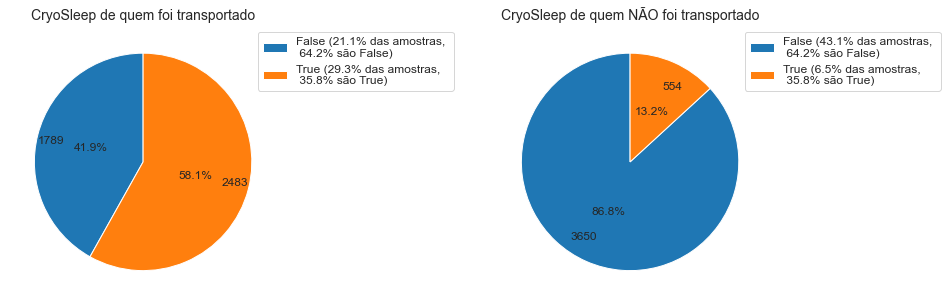

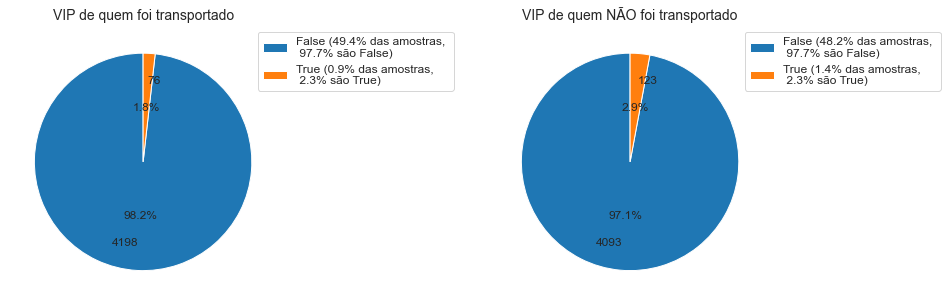

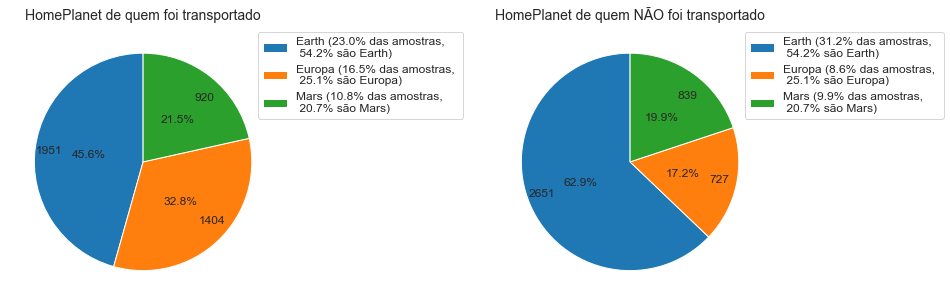

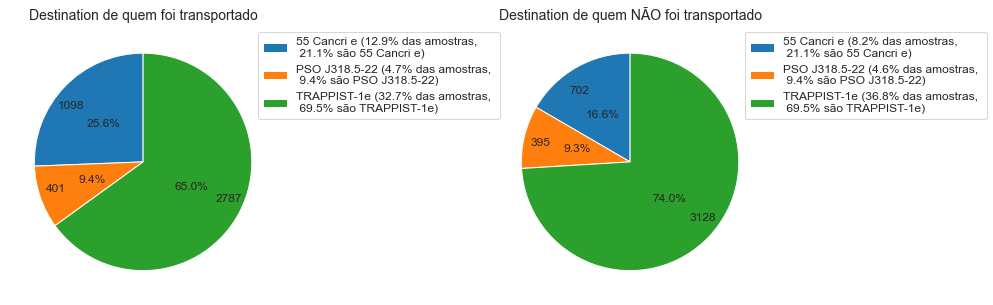

In [52]:
pieplots(train_pd, binary_features+categorical_features)

## Dados de teste

       PassengerId HomePlanet CryoSleep    Cabin  Destination          Age  \
count         4277       4190      4184     4177         4185  4186.000000   
unique        4277          3         2     3265            3          NaN   
top        0013_01      Earth     False  G/160/P  TRAPPIST-1e          NaN   
freq             1       2263      2640        8         2956          NaN   
mean           NaN        NaN       NaN      NaN          NaN    28.658146   
std            NaN        NaN       NaN      NaN          NaN    14.179072   
min            NaN        NaN       NaN      NaN          NaN     0.000000   
25%            NaN        NaN       NaN      NaN          NaN    19.000000   
50%            NaN        NaN       NaN      NaN          NaN    26.000000   
75%            NaN        NaN       NaN      NaN          NaN    37.000000   
max            NaN        NaN       NaN      NaN          NaN    79.000000   

          VIP   RoomService     FoodCourt  ShoppingMall        

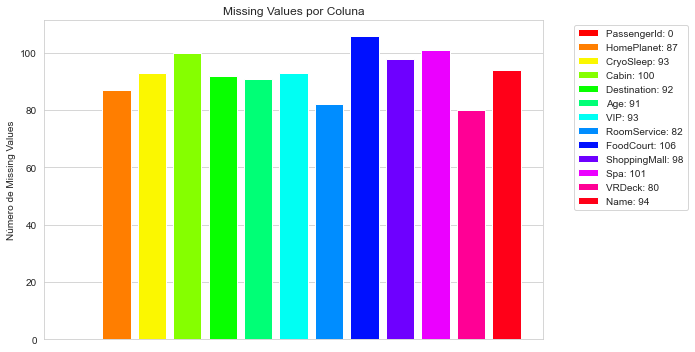

In [53]:
count_miss(test_pd)

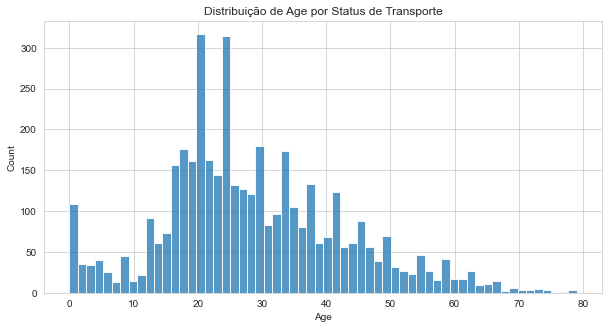

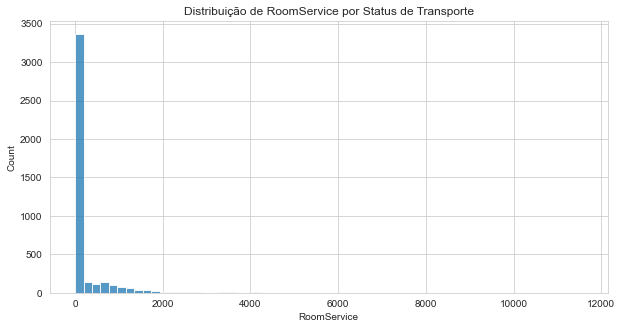

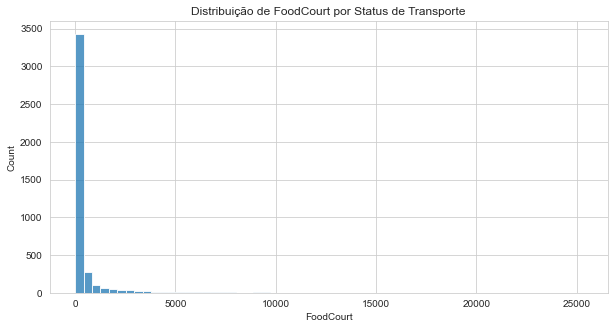

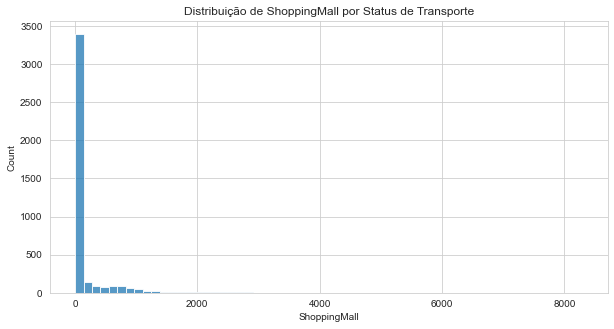

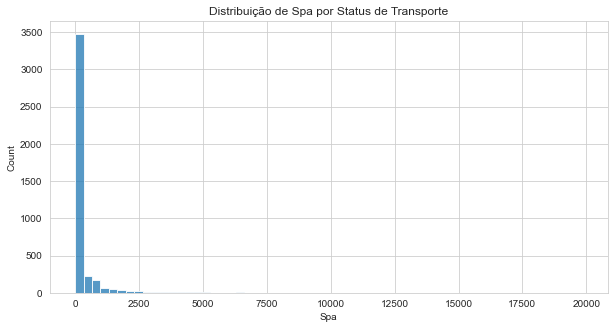

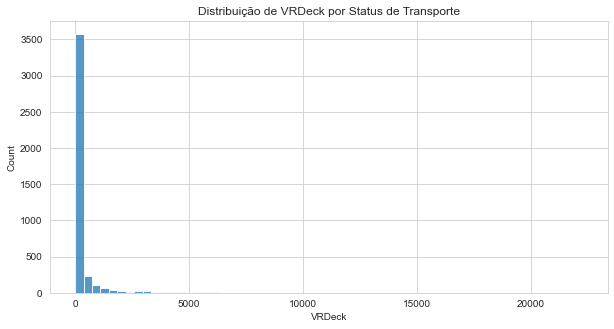

In [84]:
hist_num(test_pd, numerical_features, nolim=['Age'], dscb=False, df_test=False)

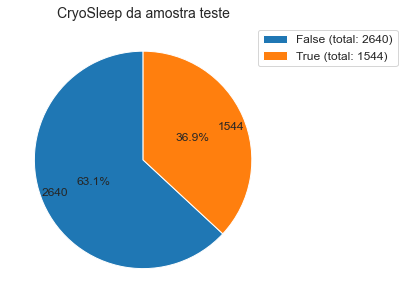

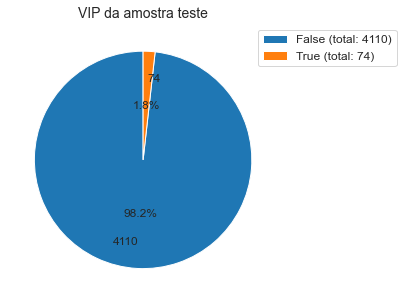

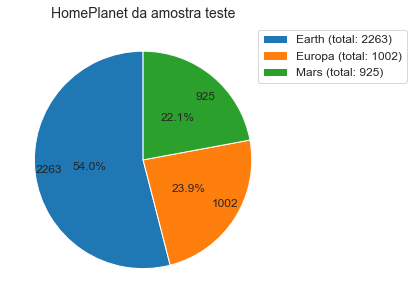

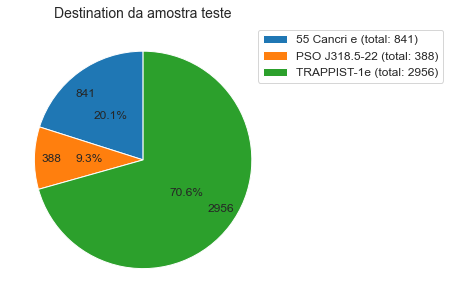

In [91]:
pieplots(test_pd, binary_features+categorical_features,dscb=False,df_test=True)